# AlexNet

In [16]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img

# Load Data and Preprocessing 

In [2]:
dataset_path = '.\\Combined_data'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path)

# Display Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
train data
actual labels: ['COVID', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']
numerical labels: tensor([0, 1, 3, 0])


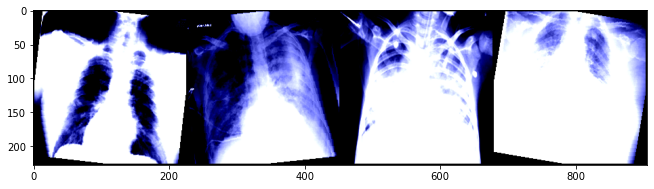

In [3]:
print('train data')
show_img(datas[0])

In [4]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([2, 1, 3, 0, 2, 0, 2, 2, 3, 0])

Validation Set:
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([0, 2, 3, 1, 3, 1, 1, 1, 2, 1])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([2, 1, 3, 3, 0, 2, 1, 2, 2, 0])


In [5]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

Length of Training: 21658
Length of Validation: 2708
Length of Testing: 2707


# AlexNet

## Settings

In [6]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

## From Scratch AlexNet

In [24]:
# class AlexNet(nn.Module):

#     def __init__(self, num_classes):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),

#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.BatchNorm2d(192),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),

#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), 256 * 6 * 6)
#         logits = self.classifier(x)
#         probas = F.softmax(logits, dim=1)
#         return logits

# torch.manual_seed(RANDOM_SEED)

# model_scratch = AlexNet(NUM_CLASSES)
# model_scratch.to(DEVICE)

# optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)  

# minibatch_loss_list_scratch, train_acc_list_scratch, valid_acc_list_scratch = train_model(num_epochs = NUM_EPOCHS, model = model_scratch, 
#                                                                 optimizer = optimizer_scratch, device = DEVICE, 
#                                                                 train_loader = train_loader, valid_loader=valid_loader, 
#                                                                 test_loader = test_loader, logging_interval=50)

# Pretrained AlexNet: fine tuned fc layer

In [18]:
model_ft = torchvision.models.alexnet(pretrained=True)
# model.classifier[4] = nn.Linear(4096, 256)
# model.classifier[6] = nn.Linear(256, 4)
for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)
model_ft

torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

# Evaluation AlexNet: fine tuned fc

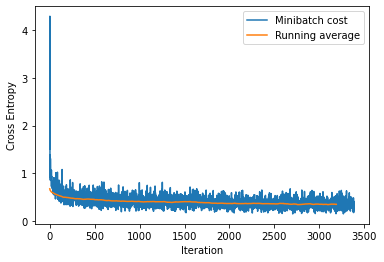

In [20]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

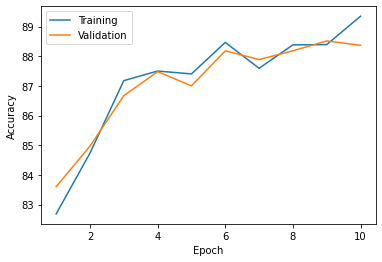

In [21]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 89.19%
Validation ACC: 89.33%
Test ACC: 87.85%


# Pretrained AlexNet fine tune fc layer + last conv layer

In [23]:
model_ft = torchvision.models.alexnet(pretrained=True)
# model.classifier[4] = nn.Linear(4096, 256)
# model.classifier[6] = nn.Linear(256, 4)
for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

NameError: name 'valid_acc_list_scratch' is not defined